## Imports

In [29]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding,Dropout,Activation,Flatten,AveragePooling1D,Conv1D,MaxPooling1D
from keras.layers import LSTM
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
import gensim 
import re
from sklearn.metrics import accuracy_score

## Constants

In [2]:
# You can dowlaod dataset from:
# https://www.kaggle.com/c/twitter-sentiment-analysis2/data
path_to_dataset = "C:/Users/arsee/Desktop/nlp/train.csv"
max_words = 100
maxlen = 80 
batch_size = 128
word2vec_size= 32

## Loading data

In [3]:
data = pd.read_csv(path_to_dataset,encoding='windows-1252')
x = data['SentimentText'].values
y = data["Sentiment"].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## Data preprocessing 

In [4]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def remove_special_symbols(sent):
    sent  =  ' '.join([w for w in sent.split() if "@" not in w])
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sent).split())

def remove_redundant_characters(word):
    return re.sub(r"(.)\1+", r"\1\1", word)

def preprocess(list_of_words):
    words = [remove_redundant_characters(w.lower()) for w in list_of_words]
    words = [w for w in words if w.isalpha()]
    words = [remove_redundant_characters(w) for w in words if w not in stop_words]
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    
    return words

In [5]:
tk = TweetTokenizer()
X_train = [remove_special_symbols(text) for text in x_train]
X_train = [tk.tokenize(text) for text in X_train]
X_train = [preprocess(sent) for sent in X_train]

X_test = [remove_special_symbols(text) for text in x_test]
X_test = [tk.tokenize(text) for text in X_test]
X_test = [preprocess(sent) for sent in X_test]

## Word2Vec training

In [6]:
word2vec_model = gensim.models.Word2Vec(
        X_train,
        size=word2vec_size,
        window=10,
        min_count=2,
        workers=10)
word2vec_model.train(X_train, total_examples=len(X_train), epochs=50)


pretrained_weights = word2vec_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape

def word2idx(word):
    if word in word2vec_model.wv.vocab:
        return word2vec_model.wv.vocab[word].index
    else:
        return vocab_size-1

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


## Most similar words for "bad"

In [7]:
word2vec_model.most_similar("bad")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('horribl', 0.7160726189613342),
 ('wors', 0.6436370015144348),
 ('worst', 0.6216478943824768),
 ('unlov', 0.6133800148963928),
 ('good', 0.6130462288856506),
 ('crap', 0.5749754905700684),
 ('nasti', 0.5736783742904663),
 ('sunbath', 0.5698460340499878),
 ('exactli', 0.5638651847839355),
 ('ugh', 0.5378111600875854)]

## Example of preprocessing data

In [8]:
for i in range(10):
    print(x_train[i]," ======> ",X_train[i])

@cathystarmaker oooo I think I need to speak to this Greg fellow, I want more tips! Looking forward to the release of his book!   ======>  ['oo', 'think', 'need', 'speak', 'greg', 'fellow', 'want', 'tip', 'look', 'forward', 'releas', 'book']
@blonddie38@beth_warren I do the belt thing and have a collection if really cool belt buckles. They don't seem to help.   ======>  ['belt', 'thing', 'collect', 'realli', 'cool', 'belt', 'buckl', 'seem', 'help']
@Celticthebest cool man, glad you enjoyed   ======>  ['cool', 'man', 'glad', 'enjoy']
@Caius it got to the stage where enough is enough   ======>  ['got', 'stage', 'enough', 'enough']
@BucketBaby I can't wait to see what kind of noise those two will make next season... How did the draft go?? I missed it ALL!!   ======>  ['wait', 'see', 'kind', 'nois', 'two', 'make', 'next', 'season', 'draft', 'go', 'miss']
@big_bad_toxman I love getting calls from extended family with 10 year old computers infested with malware and they expect me to fix it. 

## Converting to vectors

In [9]:
train_x = np.zeros([len(X_train), max_words], dtype=np.int32)
test_x = np.zeros([len(X_test), max_words], dtype=np.int32)
for i, sentence in enumerate(X_train):
      for t, word in enumerate(sentence):
            if t>=max_words:
                break
            train_x[i, t] = word2idx(word)
            
for i, sentence in enumerate(X_test):
      for t, word in enumerate(sentence):
            if t>=max_words:
                break
            test_x[i, t] = word2idx(word)

## Training and evaluating model

In [30]:
model = Sequential()
model.add(Embedding(trainable=True,input_dim=vocab_size, output_dim=emdedding_size, 
                    weights=[pretrained_weights]))
model.add(Dropout(0.25))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=emdedding_size,dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(train_x, y_train,
          batch_size=batch_size,
          epochs=15,
          
          validation_data=(test_x, y_test))
score, acc = model.evaluate(test_x, y_test,
                            batch_size=batch_size)


Train...
Train on 89990 samples, validate on 9999 samples
Epoch 1/15
89990/89990 [==============================] - 47s 527us/step - loss: 0.6386 - acc: 0.6364 - val_loss: 0.5638 - val_acc: 0.7180
Epoch 2/15
89990/89990 [==============================] - 45s 503us/step - loss: 0.5650 - acc: 0.7104 - val_loss: 0.5219 - val_acc: 0.7411
Epoch 3/15
89990/89990 [==============================] - 45s 501us/step - loss: 0.5409 - acc: 0.7235 - val_loss: 0.5127 - val_acc: 0.7445
Epoch 4/15
89990/89990 [==============================] - 46s 506us/step - loss: 0.5297 - acc: 0.7332 - val_loss: 0.5085 - val_acc: 0.7487
Epoch 5/15
89990/89990 [==============================] - 45s 498us/step - loss: 0.5197 - acc: 0.7414 - val_loss: 0.5026 - val_acc: 0.7528
Epoch 6/15
89990/89990 [==============================] - 44s 491us/step - loss: 0.5105 - acc: 0.7464 - val_loss: 0.5019 - val_acc: 0.7492
Epoch 7/15
89990/89990 [==============================] - 45s 501us/step - loss: 0.5054 - acc: 0.7503 - val_

In [34]:
print(acc)

0.7537753775615981


## Summary of model

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          485376    
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
__________

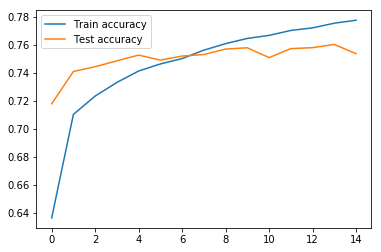

In [37]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.legend(["Train accuracy","Test accuracy "])

## Naive bayse as baseline

In [31]:
import nltk
def document_features(document):

    document_words = set(document)
    features = {}
    for word in word_features:   
        pass
        features['contains({})'.format(word)] = (word in document_words)

    return features

data = pd.read_csv(path_to_dataset,encoding='windows-1252')
x = data['SentimentText'].values[:10000] #10000 because my computer's RAM can't hol'd model for larger dataset
y = data["Sentiment"].values[:10000]
tk = TweetTokenizer()
X = [remove_special_symbols(text) for text in x]
X = [tk.tokenize(text) for text in X]
X = [preprocess(sent) for sent in X]

documents = [(list(X[i]), y[i]) for i in range(len(X))]
all_words = nltk.FreqDist([w.lower() for sent in X for w in sent ])
word_features = all_words.most_common(2000)

featuresets = [(document_features(d), c) for (d,c) in documents]
train_features ,test_features = train_test_split(featuresets, test_size=0.1, random_state=42)

## Accuracy of naive bayes

In [32]:
classifier = nltk.NaiveBayesClassifier.train(train_features)
print('Accuracy', nltk.classify.accuracy(classifier, test_features))

Accuracy 0.606
